In [1]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices()
tf.config.experimental.set_memory_growth(physical_devices[3], True)

In [2]:
from tensorflow.keras.layers import Dense,Dropout,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.models import Sequential
from collections import deque
import numpy as np
import gym
import random
import os
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

In [3]:
output_dir = os.getcwd()
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [4]:
memory_size = 15_000
gamma = 0.9995
learning_rate= 0.001
mini_batch_size = 32


state_size = (210,160,1)
n_episodes = 10_000

epsilon_max = 1
epsilon_min = 0.1

In [5]:
name= "Breakout-v0"
env = gym.make(name)
action_size = env.action_space.n
action_size

4

In [6]:
env.reset()

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [7]:
state = env.step(2)

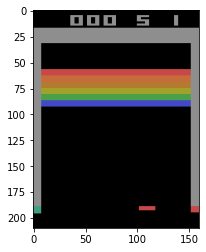

In [8]:
plt.imshow(state[0])

In [9]:
def process(state1,state2,state3,state4):
    
    def pre(state):
        s1 = state.astype('float')
        s1 = s1/255
        s1 = tf.image.resize(s1, (84, 84))
        s1 = tf.image.rgb_to_grayscale(s1)
        
        return s1
    
    st1 = pre(state1)
    st2 = pre(state2)
    st3 = pre(state3)
    st4 = pre(state4)
    
    states =  np.array(tf.concat((st1,st2,st3,st4),axis=2))
    
    states =  np.expand_dims(states,axis=0)
    
    return states



In [10]:
class DQNAgent:
    
  def __init__(self,memory_size,action_size):
    self.action_size=action_size
    self.gamma = 0.99
    self.epsilon = 1
    self.epsilon_decay = 0.999999
    self.epsilon_min = 0.1
    self.action_model  = self.build_model()
    self.target_model =  self.build_model()
    self.target_model.set_weights(self.action_model.get_weights())
    self.swap_model = self.build_model()
    self.memory = deque()   
    self.learning_rate = learning_rate

  def remember(self,state,action,reward,next_state,done):
    if len(self.memory)>memory_size:
      random.shuffle(self.memory)
      self.memory.popleft()
    self.memory.append((state,action,reward,next_state,done))

  def build_model(self):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(8,8),strides=4, activation='relu', input_shape=(84,84,4)))
    model.add(Conv2D(64, kernel_size=(4,4),strides=2, activation='relu'))
    model.add(Conv2D(64, kernel_size=(3,3), strides = 1, activation='relu'))
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(Dense(action_size,activation='linear'))
    model.compile(loss = tf.keras.losses.Huber(),optimizer = tf.keras.optimizers.Adam(lr = 0.00025))
    return model

  def act(self,state, epsilon = epsilon_min):
    if np.random.random()<=epsilon:
        return random.randrange(self.action_size)
    else:
        act_value  = self.action_model.predict(state)
        return np.argmax(act_value[0])


  def replay(self,minibatch_size):
    random.shuffle(self.memory)
    minibatch = random.sample(self.memory,mini_batch_size)
    St0 = np.zeros((1, 84, 84, 4))
    St1 = np.zeros((1, 84, 84, 4))
    for state, _, _, next_state, _ in minibatch:
        St0 = np.concatenate((St0, state), axis = 0)
        St1 = np.concatenate((St1, next_state), axis = 0)#for vectorizing the operations
      
    St0 = St0[1:]
    St1 = St1[1:]
    target_not_done = self.target_model.predict(St1)
    target_f = self.action_model.predict(St0)
    
    i = 0
    for _, action, reward, _, done in minibatch:
        target = reward
        if not done:
            target = reward  + self.gamma* np.amax(target_not_done[i])
        
        target_f[i][action] =  target
        i += 1

    self.action_model.fit(St0 , target_f, verbose= 0)
        
    if self.epsilon>self.epsilon_min:
       self.epsilon *= self.epsilon_decay

  def replace_weights(self):
    self.swap_model.set_weights(self.action_model.get_weights())
    self.action_model.set_weights(self.target_model.get_weights())

    self.target_model.set_weights(self.swap_model.get_weights())
  
  def load(self,name):
    self.action_model.load_weights(name)
    self.target_model.load_weights(name)
        
   
  def save(self,name):
    self.action_model.save_weights(name)
 

In [11]:
agent = DQNAgent(memory_size,action_size)

In [15]:
def train():
    done = False
    states = deque()
    time_step_count = 0
    env.reset()
    for i in range(4):
        init_state = env.step(random.randrange(action_size))
        states.append(init_state[0])
    updated_states = states.copy()
    current_states = process(states[0],states[1],states[2],states[3])
    
    for episode in range(n_episodes):
        env.reset()
        
        cum_reward=0
        for time_step in range(20_000):
            if time_step_count <= 1000_000* epsilon_max:
                epsilon = epsilon_max - (epsilon_max - epsilon_min) * time_step_count / (epsilon_max *1_000_000)
            else:
                epsilon = epsilon_min
            action = agent.act(current_states)
            next_state,reward,done,_=env.step(action)
            updated_states.popleft()
            
            updated_states.append(next_state)
            new_states = process(updated_states[0],updated_states[1],updated_states[2],updated_states[3])
        
            reward = reward if not done else -10
            cum_reward +=reward
            agent.remember(current_states,action,reward,new_states,done)
            #current_states
            current_states =  new_states.copy()
            #del new_states
            if time_step_count <2000:
                print(f"Time Step:{time_step_count}, Action: {action}, Reward: {reward}, Exploration: {epsilon}")

            
        
            if len(agent.memory)>4*mini_batch_size and time_step_count%4 == 0:
                agent.replay(mini_batch_size)
    
            if time_step_count%10_000 == 0:
                agent.replace_weights()
                agent.save(output_dir + '/' + 'Breakout_new'+ '.hdf5')
            
            time_step_count += 1
            
            if done:
                print(len(agent.memory))
                print("example: {}, average reward: {}, episode: {}, exploration :{}".format(time_step_count, cum_reward, episode, epsilon))
                break
              

In [16]:
def test():
    done = False
    states = deque()
    env.reset()
    time_step_count = 0
    for i in range(4):
        init_state = env.step(random.randrange(action_size))
        states.append(init_state[0])
    updated_states = states.copy()
    current_states = process(states[0],states[1],states[2],states[3])

    for episode in range(100):
    
        env.reset()
        cum_reward=0
        for time_step in range(20_000):
            action = agent.act(current_states)
            next_state,reward,done,_=env.step(action)
            env.render()
            updated_states.popleft()
            updated_states.append(next_state)
            new_states = process(updated_states[0],updated_states[1],updated_states[2],updated_states[3])
            
            reward = reward if not done else -10
            cum_reward +=reward
            del current_states
            current_states =  new_states.copy()
            del new_states
            
            if time_step_count <2000:
                print(f"Time Step:{time_step_count}, Action: {action}, Reward: {reward}")
            
            time_step_count += 1
            
            if done:
                
                print("time step: {}, average reward: {}, episode: {}".format(time_step_count, cum_reward ,episode))
                break
         
    env.close()    


In [17]:
train()

Time Step:0, Action: 2, Reward: 0.0, Exploration: 1.0
Time Step:1, Action: 2, Reward: 0.0, Exploration: 0.9999991
Time Step:2, Action: 2, Reward: 0.0, Exploration: 0.9999982
Time Step:3, Action: 2, Reward: 0.0, Exploration: 0.9999973
Time Step:4, Action: 2, Reward: 0.0, Exploration: 0.9999964
Time Step:5, Action: 2, Reward: 0.0, Exploration: 0.9999955
Time Step:6, Action: 2, Reward: 0.0, Exploration: 0.9999946
Time Step:7, Action: 2, Reward: 0.0, Exploration: 0.9999937
Time Step:8, Action: 2, Reward: 0.0, Exploration: 0.9999928
Time Step:9, Action: 2, Reward: 0.0, Exploration: 0.9999919
Time Step:10, Action: 2, Reward: 0.0, Exploration: 0.999991
Time Step:11, Action: 2, Reward: 0.0, Exploration: 0.9999901
Time Step:12, Action: 2, Reward: 0.0, Exploration: 0.9999892
Time Step:13, Action: 2, Reward: 0.0, Exploration: 0.9999883
Time Step:14, Action: 2, Reward: 0.0, Exploration: 0.9999874
Time Step:15, Action: 2, Reward: 0.0, Exploration: 0.9999865
Time Step:16, Action: 2, Reward: 0.0, Exp

KeyboardInterrupt: 